There are a few different potential corrections we can make, and I'll try to store the "final results" for all of those corrections in this notebook.

In [1]:
#import necessary packages
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from astropy.stats import sigma_clip
import matplotlib.mlab as mlab
import sys
sys.path.append("/Users/Trevor1/Desktop/git/CIV_Distance/") #wherever CIV distance repo is saved
#sys.path.append("/Users/trevormccaffrey/Desktop/git/CIV_Distance/")
from CIVfunctions import project,CIV_distance

#Default MPL colorcycle
mplcol = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [42]:
def polyfit(xdata, ydata, xrange=None):
    #perform np.polyfit 
    m, b = np.polyfit(xdata, ydata, 1)
    x = np.arange(min(xdata), max(xdata), (max(xdata)-min(xdata))/5000) if xrange is None else xrange
    y = m*x + b
    return np.array([x,y]).T

def even_fit(xdata, ydata, xrange=None):
    #Fit x vs y, then y vs x, and take the bisection of those two fits
    m1,b1 = np.polyfit(ydata, xdata, 1)
    x1 = np.linspace(ydata.min(),ydata.max(),500)
    y1 = m1*x1 + b1
    
    m2,b2 = np.polyfit(xdata, ydata, 1)
    x2 = np.linspace(xdata.min(),xdata.max(),500)
    y2 = m2*x2 + b2
    
    #Clip before determining scaling
    xdata_clipped = sigma_clip(xdata, sigma=3, maxiters=10, masked=False)
    ydata_clipped = sigma_clip(ydata, sigma=3, maxiters=10, masked=False)
    clip_mask = ((xdata>=xdata_clipped.min()) & (xdata<=xdata_clipped.max())) & ((ydata>=ydata_clipped.min()) & (ydata<=ydata_clipped.max()))
    
    #Format for sklearn scalers
    data = np.array([xdata, ydata]).T
    data_clip = np.array([xdata[clip_mask], ydata[clip_mask]]).T
    fit1 = np.array([y1, x1]).T
    fit2 = np.array([x2, y2]).T
    
    #Fit scaler on clipped data, then transform all data
    scaler = MinMaxScaler().fit(data_clip)
    data_scaled = scaler.transform(data)
    fit1_scale = scaler.transform(fit1)
    fit2_scale = scaler.transform(fit2)
    
    #Get point of intersection for two lines above
    intfit_x_scaled, intfit_y_scaled = line_intersection(fit1_scale, fit2_scale)

    #The slopes of the fits in scaled space
    m1_scale = lin_slope(fit1_scale)
    m2_scale = lin_slope(fit2_scale)

    #Get the slope splitting the angle between slopes in half - see https://www.mathstopia.net/coordinate-geometry/angle-two-lines
    phi = np.arctan((m1_scale-m2_scale)/(1+m1_scale*m2_scale))
    m_new_scaled = (m1_scale-np.tan(phi/2)) / (1+m1_scale*np.tan(phi/2))
    b_new_scaled = intfit_y_scaled - intfit_x_scaled*m_new_scaled
    x_new_scaled = np.linspace(data_scaled[:,0].min(), data_scaled[:,0].max(), 1000) if xrange is None else xrange
    y_new_scaled = m_new_scaled*x_new_scaled + b_new_scaled
    fit_new_scaled = np.array([x_new_scaled, y_new_scaled]).T

    #reverse back into normal coordinates and return fit
    fit_new = scaler.inverse_transform(fit_new_scaled)
    return fit_new

def lin_slope(line):
    #return slope of a linear fit
    return (line[1,1]-line[0,1])/(line[1,0]-line[0,0])

def line_intersection(line1, line2):
    #Get the x-y intersection of two line segments
    
    #Only care about the endpoints
    line1 = ( (line1[0,0], line1[0,1]), (line1[-1,0], line1[-1,1]) )
    line2 = ( (line2[0,0], line2[0,1]), (line2[-1,0], line2[-1,1]) )
    
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


def project_pt(pt, fit):
    #Get location of a point's orthogonal projection onto a fit
    r2 = (pt[1]-fit[:,1])**2 + (pt[0]-fit[:,0])**2
    return np.array((fit[r2.argmin(),0], fit[r2.argmin(),1]))


def perp_distance(data, xax, yax):
    #Find the distance (with sign) of each point from the yaxis
        
    disty = []
    #distx = []
    #abs_disty = []
    #abs_distx = []
    int_x, int_y = line_intersection(xax, yax) #intersection of the two new axes (the "origin")
    
    for i in range(len(data)):
        r_y = np.sqrt( (data[i,0] - yax[:,0])**2 + (data[i,1] - yax[:,1])**2 ) #dist of point i from y and x axes
        #r_x = np.sqrt( (data[i,0] - xax[:,0])**2 + (data[i,1] - xax[:,1])**2 )
        #abs_disty.append(min(r_y)) ; abs_distx.append(min(r_x))
        
        #Get which side the of the line the point is on 
        proj_x = project_pt(data[i,:], xax) #project data onto new x axis 
        side_y = 1 if (proj_x[0]>=int_x) else -1
        disty.append(side_y*min(r_y))
        
    return np.array(disty)

In [3]:
dat = pd.read_csv("/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI_wCIVDist.csv")
print("Original Data: %d objects" % dat.shape[0])
dat.head()

Original Data: 145946 objects


,Unnamed: 0,SDSS_NAME,RA,Dec,z_paul,good,nBAL,AIi,BIi,CIV_blue,...,LUM_0.2_12.0keV,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,Separation,CIV_Distance
0,0,b'003708.46+002855.8',9.285266,0.482174,3.02295,True,False,False,True,691.966469,...,NaN,0.032006,45.552314,-0.018692,3.531072,-1.0,-1.0,0.600,0.000000e+00,0.373444
1,1,b'004959.24+001903.1',12.496858,0.317540,3.32150,True,False,False,True,857.180965,...,NaN,-0.079175,12.024832,-0.040529,3.323599,-1.0,-1.0,0.375,1.144982e-11,0.618225
2,2,b'015017.70+002902.4',27.573786,0.484025,3.00333,True,False,False,True,1474.865400,...,NaN,-0.068240,1074.827534,0.183702,373.859257,-1.0,-1.0,0.167,2.289918e-11,0.681618
3,3,b'023238.49-001936.2',38.160390,-0.326749,3.34348,True,False,False,True,715.316626,...,NaN,-0.042674,229.386872,0.313899,1.875008,-1.0,-1.0,0.831,0.000000e+00,0.563721
4,4,b'072047.82+405455.5',110.199280,40.915418,3.04179,True,False,False,True,195.093283,...,NaN,-0.394990,7.126986,0.070899,32.722264,-1.0,-1.0,-0.159,0.000000e+00,0.282193


In [36]:
(del_gi<-0.3).sum(), (del_gi>0.3).sum()

(961, 18175)

In [37]:
#Only keep measurements Amy R counts as "good" - and define our full "clean" sample
good   = dat["good"].values
Mi     = dat["MI"].values
del_gi = dat["Delta_G_I"].values
clean  = good & ((Mi<0)&(Mi>-32)) & ((del_gi>-0.3)&(del_gi<0.3))
dat    = dat[clean]

Mi     = dat["MI"].values
d      = 3.08e19 #cm; =10pc
L2500  = -0.4*( Mi + 48.60 + np.log10(1+2) ) + np.log10(4*np.pi*(d**2)) #Eq 4 from Richards+ 2006, QLF paper
del_gi = dat["Delta_G_I"].values
blue   = dat["CIV_blue"].values
ew     = dat["CIV_EW"].values
z      = dat["z_paul"].values
logEW  = np.log10(ew)
HeIIEW = dat["HeII_EW"].values
CIVdist= dat["CIV_Distance"].values

print("'Clean' Data: %d objects" % dat.shape[0])
dat.head()

'Clean' Data: 121692 objects


,Unnamed: 0,SDSS_NAME,RA,Dec,z_paul,good,nBAL,AIi,BIi,CIV_blue,...,LUM_0.2_12.0keV,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,Separation,CIV_Distance
2,2,b'015017.70+002902.4',27.573786,0.484025,3.00333,True,False,False,True,1474.865400,...,NaN,-0.068240,1074.827534,0.183702,373.859257,-1.0,-1.0,0.167,2.289918e-11,0.681618
4,4,b'072047.82+405455.5',110.199280,40.915418,3.04179,True,False,False,True,195.093283,...,NaN,-0.394990,7.126986,0.070899,32.722264,-1.0,-1.0,-0.159,0.000000e+00,0.282193
5,5,b'073232.79+435500.4',113.136665,43.916780,3.46127,True,False,False,True,1705.584779,...,NaN,-0.018190,13.799765,0.045068,14.035241,-1.0,-1.0,-0.022,3.299193e-11,0.698071
6,6,b'073346.60+465836.2',113.444183,46.976735,2.19711,True,False,False,True,820.113836,...,NaN,0.347028,4.586199,-0.047932,217.287807,-1.0,-1.0,0.291,4.579999e-11,0.552542
8,8,b'074717.69+483917.4',116.823739,48.654850,1.88349,True,False,False,True,1255.186285,...,NaN,0.091723,20.541693,0.221892,269.526076,-1.0,-1.0,0.057,2.289999e-11,0.634468


In [38]:
np.sort(Mi)[:100]

array([-31.680384, -31.244665, -30.902109, -30.841909, -30.739464,
       -30.722193, -30.699034, -30.635031, -30.592457, -30.52854 ,
       -30.499477, -30.479858, -30.416908, -30.331034, -30.285093,
       -30.284439, -30.276794, -30.241941, -30.21756 , -30.213675,
       -30.198629, -30.164186, -30.11842 , -30.101875, -30.065432,
       -30.053919, -30.031975, -29.970188, -29.968639, -29.933138,
       -29.927731, -29.927227, -29.920988, -29.918028, -29.914021,
       -29.910519, -29.904192, -29.891018, -29.884315, -29.870264,
       -29.822056, -29.817772, -29.816704, -29.808359, -29.804558,
       -29.803238, -29.790771, -29.773415, -29.767792, -29.763281,
       -29.730515, -29.719666, -29.706659, -29.695284, -29.690998,
       -29.67897 , -29.678215, -29.675722, -29.658121, -29.657164,
       -29.651087, -29.650763, -29.643803, -29.637583, -29.629803,
       -29.628035, -29.620661, -29.616863, -29.5972  , -29.593819,
       -29.574347, -29.573566, -29.555803, -29.554899, -29.552

In [39]:
(L2500<-1000).sum()

0

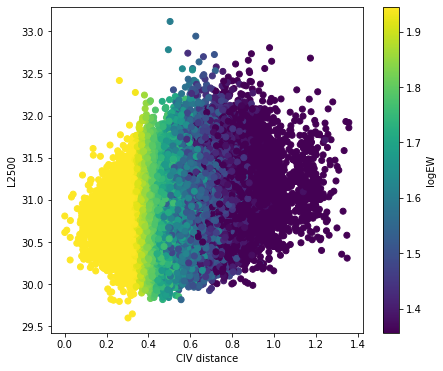

In [40]:
%matplotlib inline
def plot(x, y, c, xname="", yname="", cname=""):
    fig = plt.figure(figsize=(7,6))
    plt.scatter(x, y, c=c, vmin=np.percentile(c, 5), vmax=np.percentile(c, 95))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cname)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.show()

plot(CIVdist, L2500, logEW, "CIV distance", "L2500", "logEW")

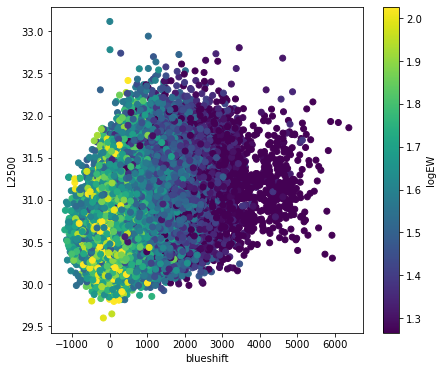

In [41]:
%matplotlib inline
def plot(x, y, c, xname="", yname="", cname=""):
    fig = plt.figure(figsize=(7,6))
    plt.scatter(x, y, c=c, vmin=np.percentile(c, 2), vmax=np.percentile(c, 98))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cname)
    plt.xlabel(xname)
    plt.ylabel(yname)
    #plt.show()

plot(blue, L2500, logEW, "blueshift", "L2500", "logEW")

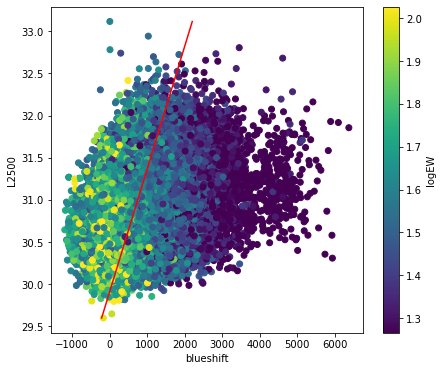

In [48]:
fit  = np.flip(polyfit(L2500, blue), axis=1)

plot(blue, L2500, logEW, "blueshift", "L2500", "logEW")
plt.gca().plot(fit[:,0], fit[:,1], "-r")

Hmm, maybe we can make some corrections?  Get a scatter of orthogonal distances of points from red line above and plot against logEW.  Using same code from UV/X-ray stuff in [``gamma_daox_diagonal_corrs_shiftdaox_4_mean_clean_3_linfits_corrections.ipynb``](https://github.com/trevormccaffrey/Cosmology_Quasars/blob/main/Xray_data/gamma_daox_diagonal_corrs_shiftdaox_4_mean_clean_3_linfits_corrections.ipynb)

In [49]:
def argmedian(data):
    return np.argsort(data)[len(data)//2]

yax    = fit.copy()
indmed = argmedian(yax[:,1]) #get index where gamma is median - just for visual purposes
data   = np.array([blue,L2500]).T

#Create and fit the scaler
scaler     = MinMaxScaler().fit(data)
data_scale = scaler.transform(data)
yax_scale  = scaler.transform(yax)

#Create a perpendicular axis in the scaled space
x_perp_scale = np.linspace(-.05, 1.05, 500)
m_perp_scale = -1 / lin_slope(yax_scale)
xi, yi = yax_scale[indmed,:]
b_perp_scale = yi - m_perp_scale*xi
xax_scale = np.array( [ x_perp_scale, m_perp_scale*x_perp_scale + b_perp_scale ] ).T
xax = scaler.inverse_transform(xax_scale)

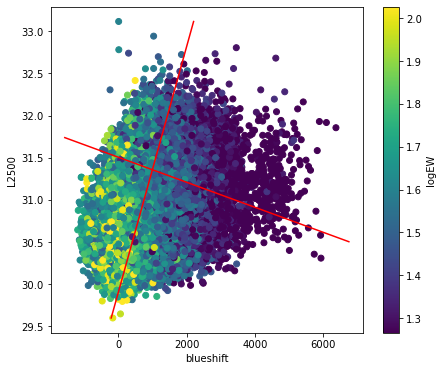

In [50]:
plot(blue, L2500, logEW, "blueshift", "L2500", "logEW")
plt.gca().plot(yax[:,0], yax[:,1], "-r")
plt.gca().plot(xax[:,0], xax[:,1], "-r")

In [51]:
dist_yax_scaled = perp_distance(data_scale, xax_scale, yax_scale)

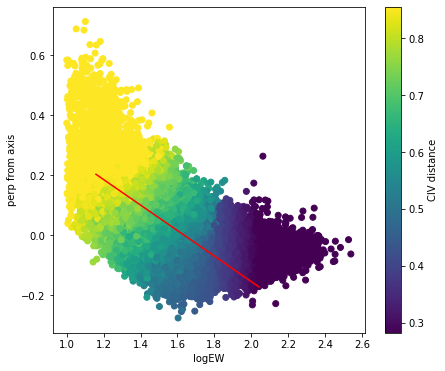

In [53]:
m, b    = np.polyfit(logEW, dist_yax_scaled, 1)
x       = np.arange(0.9, 2.3, 0.01)
y       = m*x + b
#fitperp = np.array([x,y]).T
fitperp = even_fit(logEW, dist_yax_scaled, xrange=np.linspace(0.05,0.9,100))

plot(logEW, dist_yax_scaled, CIVdist, "logEW", "perp from axis", "CIV distance")
plt.gca().plot(fitperp[:,0], fitperp[:,1], "-r")

In [54]:
def diag_shift(data, line, mag_shift):
    data_proj = project_pt(data, line)
    rvec = np.array((data_proj[0]-data[0], data_proj[1]-data[1]))
    rmag = np.linalg.norm(rvec)
    rhat = rvec / rmag
    return data + mag_shift*rhat

In [55]:
data_shift_scale = []
for i in range(len(logEW)):
    #Get index of the fitted CIV distance of point
    indperp = abs(logEW[i]-fitperp[:,0]).argmin()
    perpshift = fitperp[indperp,1]
    data_shifted = diag_shift(data_scale[i,:], yax_scale, abs(perpshift))
    data_shift_scale.append(data_shifted)
data_shift_scale = np.array(data_shift_scale)
data_shift = scaler.inverse_transform(data_shift_scale)

(-1300.0, 4400.0)

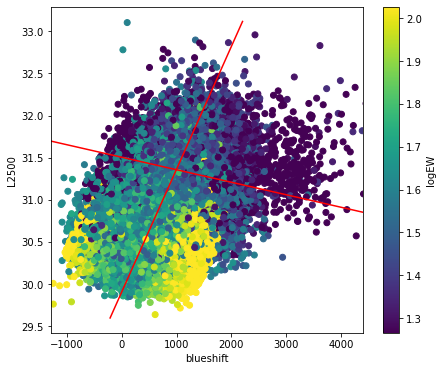

In [61]:
plot(data_shift[:,0], data_shift[:,1], logEW, "blueshift", "L2500", "logEW")
plt.gca().plot(yax[:,0], yax[:,1], "-r")
plt.gca().plot(xax[:,0], xax[:,1], "-r")
plt.gca().set_xlim(-1300,4400)
#plt.gca().scatter(blue, L2500, c="k", alpha=0.07, zorder=1)

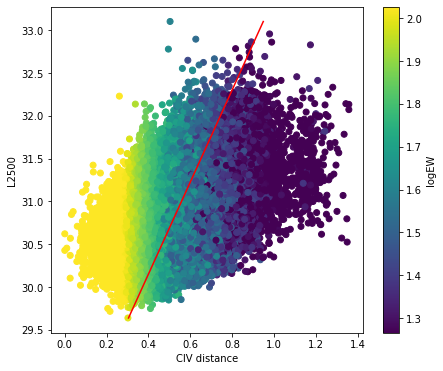

In [65]:
#fit_postshift = even_fit(CIVdist, data_shift[:,1])
fit_postshift = np.flip(polyfit(data_shift[:,1], CIVdist), axis=1)
plot(CIVdist, data_shift[:,1], logEW, "CIV distance", "L2500", "logEW")
plt.gca().plot(fit_postshift[:,0], fit_postshift[:,1], "-r")

In [66]:
yax2    = fit_postshift.copy()
indmed2 = argmedian(yax2[:,1]) #get index where gamma is median - just for visual purposes
data2   = np.array([CIVdist, data_shift[:,1]]).T

#Create and fit the scaler
scaler2     = MinMaxScaler().fit(data2)
data2_scale = scaler2.transform(data2)
yax2_scale  = scaler2.transform(yax2)

#Create a perpendicular axis in the scaled space
x2_perp_scale = np.linspace(-.05, 1.05, 500)
m2_perp_scale = -1 / lin_slope(yax2_scale)
xi2, yi2 = yax2_scale[indmed2,:]
b2_perp_scale = yi2 - m2_perp_scale*xi2
xax2_scale = np.array( [ x2_perp_scale, m2_perp_scale*x2_perp_scale + b2_perp_scale ] ).T
xax2 = scaler2.inverse_transform(xax2_scale)

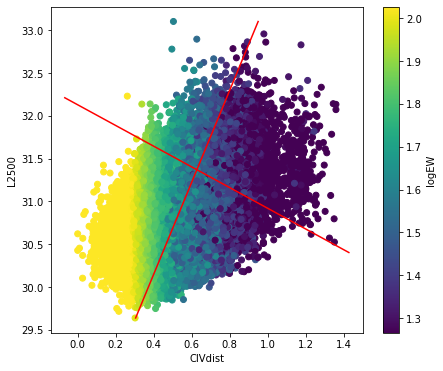

In [67]:
plot(CIVdist, data_shift[:,1], logEW, "CIVdist", "L2500", "logEW")
plt.gca().plot(yax2[:,0], yax2[:,1], "-r")
plt.gca().plot(xax2[:,0], xax2[:,1], "-r")

In [68]:
dist_yax2_scaled = perp_distance(data2_scale, xax2_scale, yax2_scale)

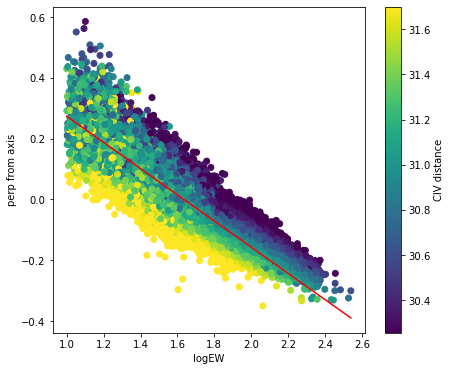

In [69]:
fitperp2 = even_fit(logEW, dist_yax2_scaled, xrange=None)
plot(logEW, dist_yax2_scaled, L2500, "logEW", "perp from axis", "CIV distance")
plt.gca().plot(fitperp2[:,0], fitperp2[:,1], "-r")

In [70]:
data_shift2_scale = []
for i in range(len(logEW)):
    #Get index of the fitted CIV distance of point
    indperp = abs(logEW[i]-fitperp2[:,0]).argmin()
    perpshift = fitperp2[indperp,1]
    data_shifted = diag_shift(data2_scale[i,:], yax2_scale, abs(perpshift))
    data_shift2_scale.append(data_shifted)
data_shift2_scale = np.array(data_shift2_scale)
data_shift2 = scaler2.inverse_transform(data_shift2_scale)

(29.0, 33.0)

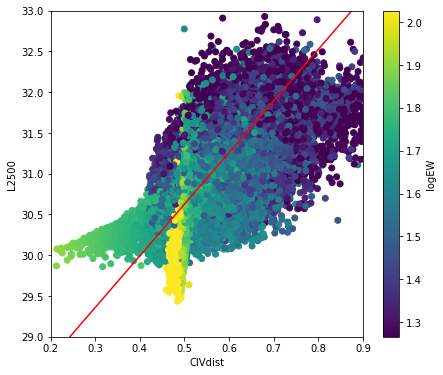

In [74]:
fit_final = even_fit(data_shift2[:,0], data_shift2[:,1])
plot(data_shift2[:,0], data_shift2[:,1], logEW, "CIVdist", "L2500", "logEW")
plt.gca().plot(fit_final[:,0], fit_final[:,1], "-r")
#plt.gca().scatter(CIVdist, L2500, c="k", alpha=0.1)
#plt.gca().plot(yax2[:,0], yax2[:,1], "-r")
#plt.gca().plot(xax2[:,0], xax2[:,1], "-r")
plt.gca().set_xlim(0.2,0.9)
plt.gca().set_ylim(29,33)

In [75]:
len(yax2)

5000

In [76]:
import emcee
from scipy.optimize import minimize

def log_likelihood(theta, x, y, xerr, yerr):
    m, b, log_disp = theta
    model = m*x + b
    sigma2 = xerr**2 + yerr**2 + np.exp(2*log_disp)
    return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )

def log_prior(theta):
    m, b, log_disp = theta
    if -6 < m < 1 and -10. < b < 10. and np.log10(0.0001) < log_disp < np.log10(0.5):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

def mcmc_fit(x, y, xerr, yerr):
    #to plot on the flux grid
    x0 = np.linspace(x.min(), x.max(), 10)
    
    #First just find ML fit for MCMC initialization
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([0.9, -0.4, np.log(0.4)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, xerr, yerr))
    m_ml, b_ml, log_disp_ml = soln.x
    
    #Initalize and run MCMC
    pos = soln.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, xerr, yerr))
    sampler.run_mcmc(pos, 5000, progress=True)
    
    #Remove the "burn-in" period
    try:
        tau = sampler.get_autocorr_time()
        discard = int(2*np.mean(tau)) if ~np.isnan(np.mean(tau)) else 1000
        flat_samples = sampler.get_chain(discard=discard, thin=15, flat=True)
    except:
        flat_samples = sampler.get_chain(thin=15, flat=True)
        
    #Return gamma+uncertainties, dispersion
    return np.percentile(flat_samples[:, 0], [16, 50, 84]), np.exp(np.percentile(flat_samples[:, 2], [50]))

In [77]:
reg_params  = mcmc_fit(CIVdist, L2500, np.zeros(len(CIVdist)), np.zeros(len(L2500)))
corr_params = mcmc_fit(data_shift2[:,0], data_shift2[:,1], np.zeros(len(data_shift2[:,0])), np.zeros(len(data_shift2[:,1])))

<ipython-input-76-ff2131677595>:8: RuntimeWarning: divide by zero encountered in true_divide
  return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )
<ipython-input-76-ff2131677595>:8: RuntimeWarning: divide by zero encountered in log
  return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )
<ipython-input-76-ff2131677595>:8: RuntimeWarning: invalid value encountered in add
  return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )
<ipython-input-76-ff2131677595>:8: RuntimeWarning: divide by zero encountered in true_divide
  return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )
<ipython-input-76-ff2131677595>:8: RuntimeWarning: divide by zero encountered in log
  return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )
<ipython-input-76-ff2131677595>:8: RuntimeWarning: invalid value encountered in add
  return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )
<ipython-input-76-ff2131677595>:8: RuntimeWarning: divide by z

In [78]:
print("Parameters for fits above:\n")
print("Regular: Slope = %.4f±%.4f, Dispersion = %.4f" % (reg_params[0][0], reg_params[0][1]-reg_params[0][0], reg_params[1][0]))
print("Shifted: Slope = %.4f±%.4f, Dispersion = %.4f" % (corr_params[0][0], corr_params[0][1]-corr_params[0][0], corr_params[1][0]))

Parameters for fits above:

Regular: Slope = 8987406.5638±0.0001, Dispersion = 0.0000
Shifted: Slope = 10993925.3602±0.0001, Dispersion = 0.0000


The dispersion is pretty big still, but IDK, maybe we could have something if we apply this to ~150k quasars instead.  Try doing this with full Rankine+20 sample in part 2 of this notebook; then, if that works, I'll try building Beta's Hubble diagram.